# Import libraries

In [1]:
import math
import pandas as pd
import numpy as np
from numpy import random as rnd

from tsad.evaluating.evaluating import evaluating #F1 score
from detecta import detect_cusum #CUMSUM

import matplotlib.pyplot as plt

import requests
from io import StringIO

import sys
sys.path.append(r'/home/gishb/PycharmProjects/Fedot.Industrial') #SST
from core.operation.transformation.WindowSelection import WindowSizeSelection
from core.models.detection.subspaces.SSTdetector import SingularSpectrumTransformation

from scipy.signal import butter, filtfilt
from optcutfreq import optcutfreq

from scipy.signal import savgol_filter

# Import data

In [2]:
def df_expirement():
    url = "https://storage.yandexcloud.net/cloud-files-public/dataframe.csv" 
    df = pd.read_csv(StringIO(requests.get(url).content.decode('utf-8')), sep='|')
    return df

# Data generation

In [3]:
df = df_expirement()
df_columns = df.columns 
first_label_list = df[df_columns[0]].unique() 
df_aa564g = df[df[df_columns[0]] == first_label_list[0]]
df_aa564g_first = df_aa564g.drop(axis=1, labels=(df_aa564g.columns[0])) \
    .drop(axis=1, labels=(df_aa564g.columns[1]))[['uR/h', 'unitless']].reset_index(drop=True)
df = df_aa564g_first.loc[df_aa564g_first['unitless'] >= 0]\
            .loc[df_aa564g_first['uR/h'] >= 0].reset_index(drop=True)

df['change_points'] = [1 if df['unitless'][i] !=  df['unitless'][i+1] else 0 for i in range(len(df)-1)] + [0]
df['time'] = np.arange(0, len(df)*1, 1).astype('datetime64[s]')
df = df.set_index('time')

# Breef look at data

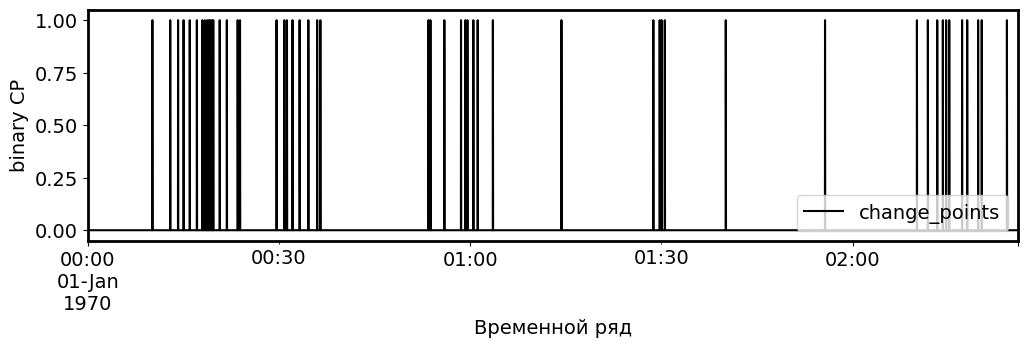

 Number CP: 52
 len data: 8754


In [4]:
df.change_points.plot(figsize=(12,3), color='black')
plt.legend(loc="lower right",)
plt.xlabel('Временной ряд')
plt.ylabel('binary CP')
plt.show()
print(f' Number CP: {df[df["change_points"] == 1].count()[0]}')
print(f' len data: {df.count()[0]}')

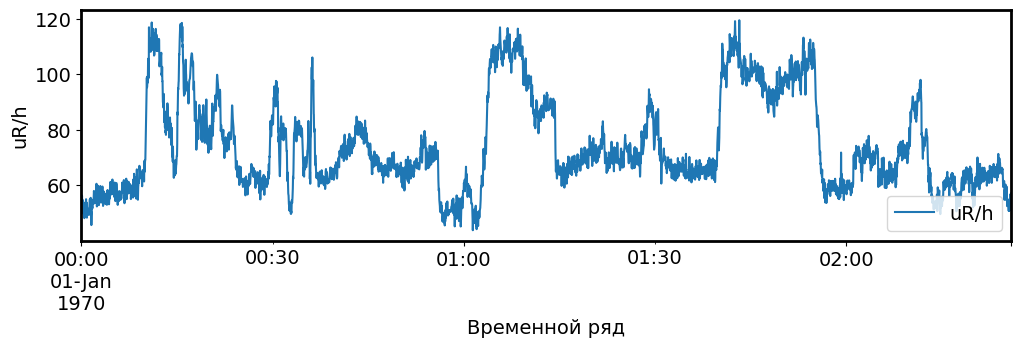

In [5]:
df['uR/h'].plot(figsize=(12,3))
plt.legend(loc="lower right")
plt.xlabel('Временной ряд')
plt.ylabel('uR/h')
plt.show()

# Define filters & cumsumm & TSAD metric

In [6]:
def filter_butterworth(ts, freq): #list, int(1)
    '''
        Just butterworh filter
    '''
    fc_opt = optcutfreq(ts, freq=freq, show=False)

    C = 0.802 # for dual pass; C = (2**(1/npasses) - 1)**0.25
    b, a = butter(2, (fc_opt/C)/(freq/2))
    dispf = filtfilt(b, a, ts)
    aaccBW =  np.diff(dispf, 2)*fc_opt*fc_opt
    return aaccBW

def cumsum(x):
    '''
        Just CUMSUM filter
    '''
    ending, start, alarm, cumsum = detect_cusum(x, np.mean(x)+3*np.std(x), np.std(x), True, False)
    return ending, start, alarm, cumsum 

def filter_Savgol(x, window_length):
    '''
        Savitzky-Golay filter from scipy
    '''
    aaccSG = savgol_filter(x, window_length, 3, mode='nearest')
    return np.array(aaccSG)

def tsad_average(predicted_list, original_list):
    averate_time, missed_cp, FPs, true_anomalies = evaluating(original_list, predicted_list, metric='average_time', numenta_time='30 sec', verbose=False)
    TP = true_anomalies - missed_cp
    precision = TP/(TP+FPs)
    recall = TP/(TP+missed_cp)
    F1 = 2*precision*recall/(precision+recall)
    return {'Time_Delta': averate_time, 'Missed_CP': missed_cp, 'FPs': FPs, 'True_Anomalies_Count': true_anomalies, 'precision':precision, 'recall':recall,'F1':F1}

def tsad_nab(predicted_list, original_list):
    nab = evaluating(original_list, predicted_list, metric='nab', numenta_time='30 sec', verbose=False)
    return nab

def normalization_linear(x):
    return (x-min(x))/(max(x)-min(x))

# Time series feature engineering

In [7]:
time_series = np.array(df['uR/h'])
# ts_butterworth = filter_butterworth(time_series, 1)
ts_savgol = filter_Savgol(time_series, 60)
print(f'time series.shape: {time_series.shape}')

time series.shape: (8754,)


# Search and set hyperparameters

In [8]:
window_length = WindowSizeSelection(time_series = list(ts_savgol[:int(len(ts_savgol)/2)]),
                                       wss_algorithm = 'highest_autocorrelation').runner_wss()[0]
trajectory_window_length = WindowSizeSelection(time_series = list(ts_savgol[:window_length]), window_max = window_length,  wss_algorithm = 'summary_statistics_subsequence').runner_wss()[0]
lag = int(window_length/4)
print(f'Window: {window_length}, trajectory_window: {trajectory_window_length}, lag: {lag}')

Window: 278, trajectory_window: 47, lag: 69


# Define SST model

In [9]:
model = SingularSpectrumTransformation(time_series=ts_savgol, quantile_rate=0.98,
                                       trajectory_window_length=trajectory_window_length,
                                       ts_window_length=window_length, lag=lag, view=False)

In [10]:
score_sst = model.score_offline(dynamic_mode=True)

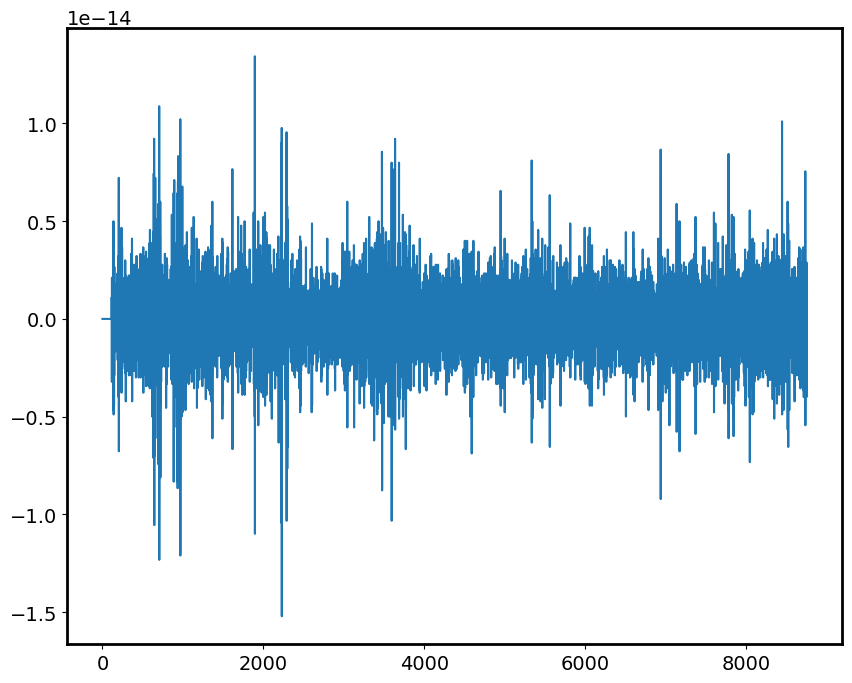

In [11]:
plt.plot(score_sst)

In [20]:
df['score_SST'] = list(score_sst) + [0]*abs(int(len(score_sst)-len(time_series))) #Проблема с длинною time_series. Почему?

# Kalman Filter method
Bayesian method used to find residuals which leads to ChangePoints

In [21]:
from itertools import chain # list of list to one bit list
from collections import namedtuple
gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: '𝒩(μ={:.3f}, 𝜎²={:.3f})'.format(s[0], s[1])

In [22]:
def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, variance)

def update(prior, likelihood):
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)

def list_measured_function(window_size, ts):
    list_measured_pos = []
    for i in range(0, len(ts), window_size):
        temp = list(ts[i:i+window_size])
        mean_ts, var_ts = np.mean(temp), np.var(temp)
        list_measured_pos.append(gaussian(mean_ts, var_ts))
    return list_measured_pos

def make_one_step_prediction(list_measured_pos, g=gaussian(100, .1800**2), window=10):
    list_prediction, predictions_x = [], []
    for i in range(1,len(list_measured_pos)):
        prior = predict(list_measured_pos[i-1], g)
        likelihood = list_measured_pos[i-1]
        x = update(prior, likelihood)
        predictions_x.append(np.random.normal(loc=x.mean, scale=x.var, size=window))
        list_prediction.append(x)
    print()
    print('final estimate:        {:10.3f}'.format(list_prediction[-1].mean))
    print('actual final position: {:10.3f}'.format(list_measured_pos[-1].mean))
    return list_prediction, predictions_x

In [23]:
list_measured_pos = list_measured_function(window_size= window_length,
                                           ts = ts_savgol)
list_prediction, list_x_mean = make_one_step_prediction(list_measured_pos,
                                                        g=gaussian(1, .18**2),
                                                        window = window_length)


final estimate:            63.316
actual final position:     60.184


In [24]:
new_list = list(map(int, chain.from_iterable(list_x_mean)))
new_list = new_list + [0]*(len(df) - len(new_list))

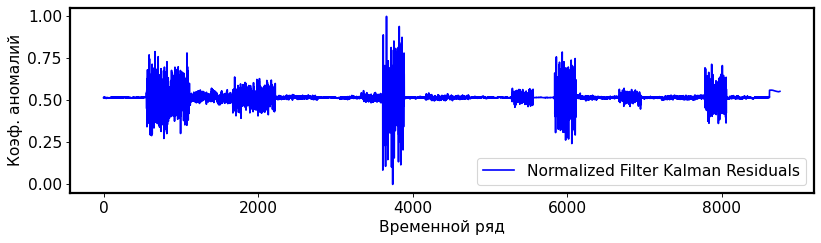

In [25]:
risiduals_kalman_ts = normalization_linear(np.array(ts_savgol)-np.array(new_list))
plt.figure(figsize=(12, 3), dpi=80)
plt.plot(risiduals_kalman_ts, color='blue', label='Normalized Filter Kalman Residuals')
plt.legend(loc="lower right")
plt.xlabel('Временной ряд')
plt.ylabel('Коэф. аномалий')
plt.show()

In [26]:
treshold_kalman = np.std(risiduals_kalman_ts)*2 + np.mean(risiduals_kalman_ts)
print(f'Kalman treshold: {treshold_kalman}')

Kalman treshold: 0.606551852841587


In [27]:
score_kalman = [1 if risiduals_kalman_ts[i] > treshold_kalman else 0 for i in range(risiduals_kalman_ts.shape[0])]

In [28]:
df['score_kalman'] = score_kalman

# Make one prediction for normalized series with SST and Filtrer Kalman

In [29]:
SST_Kalman_CPs_test = [150 if score_kalman[i]+score_sst[i] >= 1 else 0 for i in range(len(score_sst))]
SST_Kalman_CPs = [1 if score_kalman[i]+score_sst[i] >= 1 else 0 for i in range(len(score_sst))]

# Define queue filter

In [30]:
def queue(queue_window=10, time_series=None):
    queue = [0]*queue_window
    filtered_score = []
    for i in range(len(time_series)):
        value = time_series[i]
        if max(queue) != 0: #Вариант при котором CPs уже в очереди
            filtered_score.append(0)
            queue.pop(0)
            queue.append(0)
        else: # В очереди нет CPs
            filtered_score.append(value)
            queue.pop(0)
            queue.append(value)
    return filtered_score

# GreedSearch filter window

In [31]:
window_range = np.arange(1, 100+1)
list_scores_ = list()

In [32]:
%%capture
for i in window_range:
    temp_list = queue(queue_window=i, time_series=SST_Kalman_CPs)
    df['temp'] = temp_list + [0]*abs(len(temp_list) - len(df))
    list_scores_.append(tsad_average(df.temp, df.change_points))

In [43]:
test_cp = [list_scores_[i]['Missed_CP'] for i in range(len(list_scores_))]
test_averagetime = [list_scores_[i]['Time_Delta'].seconds for i in range(len(list_scores_))]

47


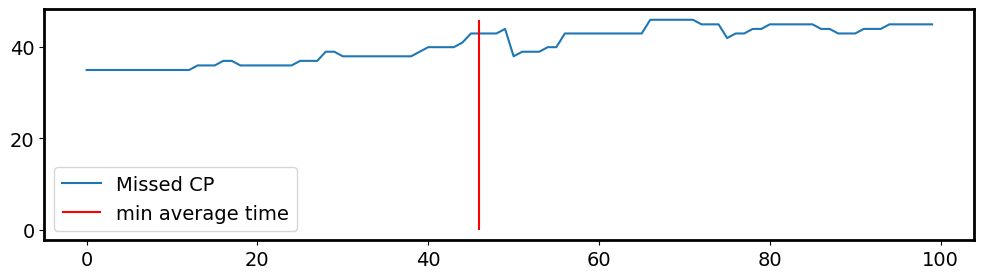

In [54]:
plt.figure(figsize=(12,3))
plt.plot(test_cp, label='Missed CP')
#plt.plot(test_averagetime, label='Time')
plt.vlines(test_averagetime.index(min(test_averagetime)),ymin=0, ymax=max(test_cp), color='red', label='min average time')
plt.legend()

best_window = test_averagetime.index(min(test_averagetime))+1
print(best_window)

47


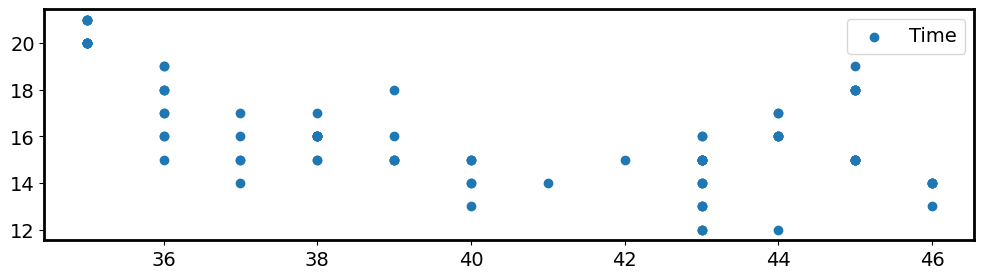

In [61]:
plt.figure(figsize=(12,3))
#plt.plot(test_cp, label='Missed CP')
plt.scatter(test_cp, test_averagetime, label='Time')
#plt.vlines(test_averagetime.index(min(test_averagetime)),ymin=0, ymax=max(test_cp), color='red', label='min average time')
plt.legend()

best_window = test_averagetime.index(min(test_averagetime))+1
print(best_window)

# Define best window for queue filter

In [55]:
SST_Kalman_queue_CPs = queue(queue_window=best_window, time_series=SST_Kalman_CPs)
df['SST_Kalman_queue_CPs'] = SST_Kalman_queue_CPs+ [0]*abs(len(SST_Kalman_queue_CPs) - len(df))

SST_Kalman_queue_CPs_test = queue(queue_window=best_window, time_series= SST_Kalman_CPs_test)
df['SST_Kalman_queue_CPs_test'] = SST_Kalman_queue_CPs_test + [0]*abs(len(SST_Kalman_queue_CPs_test) - len(df))

# Create report

In [56]:
def create_report(experiment_results: dict):
    experiment_df = pd.DataFrame.from_dict(experiment_results, orient='index')
    experiment_df = experiment_df.fillna(0)
    return experiment_df

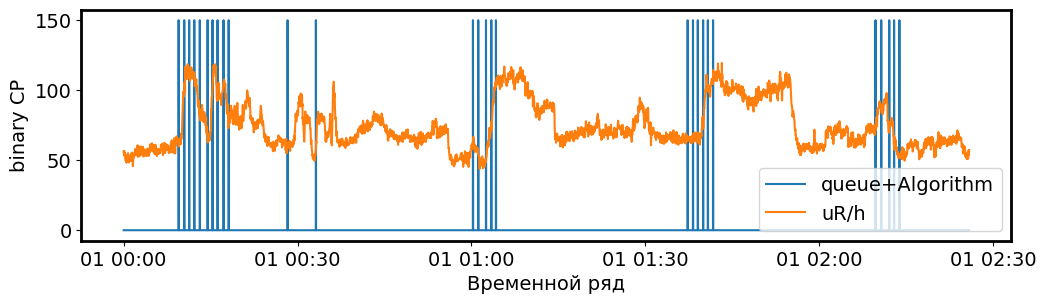

In [57]:
plt.figure(figsize=(12,3))
plt.plot(df['SST_Kalman_queue_CPs_test'], label='queue+Algorithm')
plt.plot(df['uR/h'], label='uR/h')
plt.legend(loc="lower right",)
plt.xlabel('Временной ряд')
plt.ylabel('binary CP')
plt.show()

In [75]:
%%capture --no-display
tsad_average_results = tsad_average(df.SST_Kalman_queue_CPs, df.change_points)

In [76]:
%%capture --no-display
tsad_nab_results = tsad_nab(df.SST_Kalman_queue_CPs, df.change_points)

In [78]:
tsad_nab_results.update(tsad_average_results)
create_report(tsad_nab_results)

,0
Standart,22.43
LowFP,11.69
LowFN,30.34
Time_Delta,0 days 00:00:12.333333333
Missed_CP,28
FPs,88
True_Anomalies_Count,52
precision,0.214286
recall,0.461538
F1,0.292683


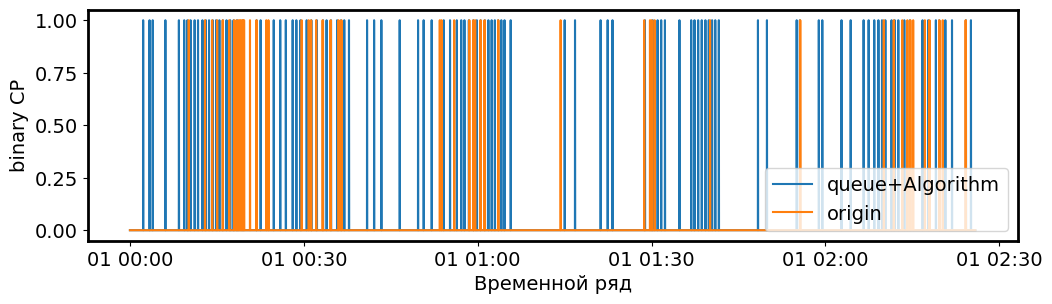

In [79]:
plt.figure(figsize=(12,3))
plt.plot(df['SST_Kalman_queue_CPs'], label='queue+Algorithm')
plt.plot(df['change_points'], label='origin')
plt.legend(loc="lower right",)
plt.xlabel('Временной ряд')
plt.ylabel('binary CP')
plt.show()